In [58]:
import torch
from torch import nn
import lightning
from einops import rearrange
from einops import repeat
from torch.nn import functional as F

In [59]:
class ImagePathces(nn.Module):
    def __init__(self, img_size, in_ch:int = 3,patch_size: int = 16):
        super().__init__()
        assert img_size % patch_size == 0

        emb_dim = patch_size * patch_size * in_ch
        self.cls_token = nn.Parameter(torch.randn(1,1,emb_dim))

        self.pos_emb = nn.Parameter(torch.randn(1,1+(img_size//patch_size)**2,emb_dim))
        
        self.patches = nn.Conv2d(in_ch,emb_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.patches(x)

        # x = torch.flatten(x,2)
        # b, e, hw = x.shape
        # x = x.reshape((b,hw,e))
        x = rearrange(x, "b e h w -> b (h w) e")
        
        b, _, _ = x.shape

        #cls_token = self.cls_token.repeat((b,1,1))
        cls_token = repeat(self.cls_token,"() s e -> b s e",b=b)

        x = torch.concat((cls_token, x),dim=1)

        return x + self.pos_emb 

In [60]:
patch = ImagePathces(224,3)
x = torch.randn(2, 3, 224, 224)
patches = patch(x)
patches

tensor([[[ 0.4626, -0.0470,  0.2544,  ..., -2.6658, -1.4862, -0.7106],
         [-2.3378,  0.1920,  0.3672,  ..., -2.1694,  1.0998, -0.4936],
         [ 0.6476, -0.1898, -1.6607,  ...,  0.6751, -2.0205,  1.0907],
         ...,
         [-1.5856, -0.0727, -1.5754,  ...,  1.2539,  0.0736,  1.1453],
         [-0.0046,  0.9536, -1.8399,  ..., -0.7205, -0.2709, -0.6958],
         [ 0.5433, -2.4332,  1.8318,  ..., -1.4578, -1.5394, -0.6127]],

        [[ 0.4626, -0.0470,  0.2544,  ..., -2.6658, -1.4862, -0.7106],
         [-2.1221,  0.9999,  0.6679,  ..., -2.4711,  0.7421, -0.1767],
         [-0.3135, -0.4021, -1.0341,  ...,  0.2260, -1.9319,  1.4878],
         ...,
         [-1.9408, -0.1953, -0.7337,  ...,  0.5273,  0.5717,  1.5941],
         [ 0.2360,  0.7556, -1.9966,  ...,  0.2253,  0.8419, -1.2392],
         [ 0.6351, -2.9221,  1.7094,  ..., -2.7709, -0.1879, -1.3557]]],
       grad_fn=<AddBackward0>)

In [61]:
class MLP(nn.Module):
    def __init__(self,input_size: int, hidden_size: int = None, output_size: int = None, droput = 0.,layer_act: torch.nn = nn.GELU) -> None:
        super().__init__()
        if hidden_size is None:
            hidden_size = input_size
        if output_size is None:
            output_size = input_size

        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,output_size)
        self.actv = layer_act()
        self.drop = nn.Dropout(droput)

    def forward(self,x):
        return self.drop(self.fc2(self.actv(self.fc1(x))))

In [62]:
mlp = MLP(234,345,10,droput=0.2,layer_act=nn.ReLU)

x = torch.randn((2,234))

mlp(x).shape

torch.Size([2, 10])

In [63]:
class Attention(nn.Module):
    def __init__(self,dim: int,qkv_bias: bool = False, num_heads: int =8, attn_drop=0., out_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim,dim*3,bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.out_drop = nn.Dropout(out_drop)
        self.out_lin = nn.Linear(dim,dim)

    def forward(self,x):
        x = self.qkv(x)
        b, e, _ = x.shape
        # b e (q k v)
        x = x.reshape((b,3,self.num_heads,e,-1))
        # b qkv heads e s 
        
        att = F.softmax((x[:,0] @ x[:,1].transpose(2,3))*self.scale, dim=2)

        att = self.attn_drop(att @ x[:,2])
        
        #out = out.reshape(b,e,-1)
        att = rearrange(att, "b h n e -> b n (h e)")

        out = self.out_drop(self.out_lin(att))

        return out

In [64]:
att = Attention(768)
att(patches).shape

torch.Size([2, 197, 768])

In [65]:
class Block(nn.Module):
    def __init__(self, dim, qkv_bias: bool = False, num_heads:int = 8, mlp_ratio:int = 4, drop_rate: float = 0.) -> None:
        super().__init__()
        self.att = Attention(dim,num_heads=num_heads,qkv_bias=qkv_bias)

        self.att_norm = nn.LayerNorm(dim)

        self.mlp = MLP(dim,dim*mlp_ratio,dim)
        
        self.mlp_norm = nn.LayerNorm(dim)
        

    def forward(self, x):
        att = self.att(x)
        att_out = self.att_norm(x + att)

        mlp = self.mlp(att_out)
        mlp_out = self.mlp_norm(x + mlp)
        return mlp_out

In [66]:
bl = Block(768)

bl(patches).shape

torch.Size([2, 197, 768])

In [67]:
class Encoder(nn.Module):
    def __init__(self, dim, qkv_bias: bool = False, N:int = 6, num_heads: int = 8, mlp_ratio: int = 4, drop_rate: float = 0.) -> None:
        super().__init__()
        self.blocks =nn.ModuleList([
            Block(dim,qkv_bias,num_heads,mlp_ratio,drop_rate)
        for _ in range(N)
        ])

    def forward(self,x):
        for block in self.blocks:
            x = block(x)
        return x

In [68]:
enc = Encoder(768)

enc(patches).shape

torch.Size([2, 197, 768])

In [83]:
class ViT(nn.Module):
    def __init__(self, img_size: int, patch_size: int, num_classes: int, 
                 in_ch: int = 3, depth: int=6, num_heads: int = 8, 
                 mlp_ratio: int = 4, qkv_bias=False, drop_rate: float = 0.) -> None:
        super().__init__()

        emb_dim = in_ch*patch_size**2
        
        self.patch = ImagePathces(img_size = img_size,
                                  in_ch = in_ch,
                                  patch_size = patch_size)

        self.encoder = Encoder(dim = emb_dim,
                               qkv_bias = qkv_bias,
                               N = depth,
                               num_heads = num_heads,
                               mlp_ratio = mlp_ratio,
                               drop_rate = drop_rate)
        
        self.mlp_head = nn.Linear(emb_dim,num_classes)
    
    def forward(self,x):
        x = self.patch(x)

        x = self.encoder(x)

        x = self.mlp_head(x)
        return F.softmax(x[:,0],dim=1)

In [84]:
x = torch.randn(2, 3, 224, 224)

In [85]:
vit = ViT(img_size=224,
          patch_size=16,
          num_classes=10)

In [86]:
vit(x).shape

torch.Size([2, 10])

In [8]:
import torch
from torch.utils.data import DataLoader
import lightning as L
from typing import Any, Tuple
from torchmetrics.functional import accuracy, auroc
from cifar_cnn.models.SKConv import SKConv
from cifar_cnn.models.vit import ViT
from torch.nn import functional as F


class Model(L.LightningModule):
    def __init__(self, img_size: int, patch_size: int, num_classes: int, 
                 in_ch: int = 3, depth: int=6, num_heads: int = 8, 
                 mlp_ratio: int = 4, qkv_bias=False, drop_rate: float = 0.,
                 lr=1e-5,in_channels:int = 3,out_channels: int = 4,) -> None:
        super().__init__()

        self.num_classes = num_classes
        self.learning_rate = lr

        self.skconv = SKConv(in_channels,out_channels,groups=1)

        self.ViT =  ViT(img_size=img_size,
                        patch_size=patch_size,
                        num_classes=num_classes,
                        in_ch=in_ch,
                        depth=depth,
                        num_heads=num_heads,
                        mlp_ratio=mlp_ratio,
                        drop_rate=drop_rate)


    def forward(self,x):
        x = self.skconv(x)
        x = self.ViT(x)
        return x

        
    def training_step(self, batch, batch_nb: int):
        x,y = batch

        preds = self(x)
        loss = F.cross_entropy(preds,y)
        
        return {'loss': loss, 'prediction': preds}
    
    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        """
        metrics
        """
        rocauc = auroc(logits,y,task="multiclass",num_classes=self.num_classes)
        acc = accuracy(logits, y, task="multiclass",num_classes=self.num_classes)
        self.log("val_accuracy", acc, prog_bar=True)
        self.log("val_rocauc",rocauc,prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)

    def test_step(self,batch: Tuple[torch.Tensor, torch.Tensor], batch_idx):
        x, y = batch
        logits = self(x)
        
        test_loss = F.cross_entropy(logits, y)
        """
        metrics
        """
        rocauc = auroc(logits,y,task="multiclass",num_classes=self.num_classes)
        acc = accuracy(logits, y, task="multiclass",num_classes=self.num_classes)
        self.log("test_accuracy", acc, prog_bar=True)
        self.log("test_rocauc",rocauc,prog_bar=True)
        self.log("test_loss", test_loss, prog_bar=True)

    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), self.learning_rate)

        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer=optimizer,patience=5),
            "monitor": "val_loss"
        }
        
        return {"optimizer": optimizer, "lr_scheduler":scheduler}

In [6]:
from torchvision.datasets import STL10, CIFAR10
from torchvision.transforms import transforms
import numpy as np
import matplotlib.pyplot as plt

In [7]:
dt =CIFAR10("/CIFAR10/datasets/raw", train=True, download=True)

Files already downloaded and verified


In [8]:
dt.data.shape

(50000, 32, 32, 3)

In [9]:
dt = STL10("/CIFAR10/datasets/raw",split="train",download=True)

Files already downloaded and verified


In [22]:
dt.data =dt.data.transpose(0,2,3,1)

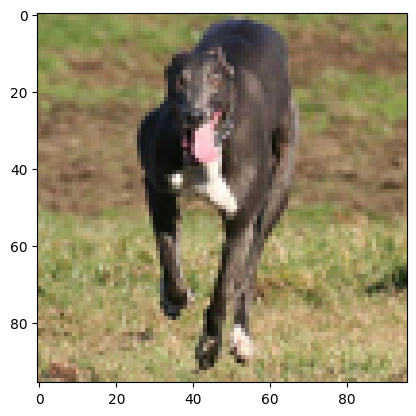

In [24]:
plt.imshow(dt.data[1])

In [7]:
dt.data.shape

(5000, 3, 96, 96)

In [8]:
transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) 
            ]
        )
dims = (3,32,32)
num_classes = 10

In [9]:
dt = STL10("/CIFAR10/datasets/raw",split="train",download=True,transform=transform)

Files already downloaded and verified


### Training

In [1]:
from typing import List, Union
from cifar_cnn.data.data_loader import CIFAR10DataModule, STL10DataModule
#from cifar_cnn.models.cnn import CIFAR10Model
from cifar_cnn.models.vit import ViT
import torch
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import wandb

ACCELERATOR = "gpu" if torch.cuda.is_available() else "cpu"
CONF = {
    "architecture": "ViT", 
    "batch_size": 48,
    "dataset": "STL10"
    }
PARAMS = {
        "lr":1e-5,
        # "in_channels":3,
        # "out_channels":4,
        "img_size":96,
        "patch_size":16,
        "num_classes":10,
        "in_ch":3,
        "mlp_ratio": 4,
        "depth":24,
        "num_heads":16,
        "drop_rate":0.05,
    }


class ImageCallback(L.Callback):
    def __init__(self) -> None:
        super().__init__()
        self.outputs = None
        self.x = None
        self.y = None


    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        if batch_idx == trainer.num_training_batches-1:
            self.x, self.y = batch
            self.outputs = torch.argmax(outputs["prediction"],dim=1)


    def on_train_epoch_end(self, trainer, pl_module):
        n = 10
        x, y = self.x, self.y

        images = [img for img in x[:n]]
        captions = [f'Target: {y_i} - Prediction: {y_pred}' 
            for y_i, y_pred in zip(y[:n], self.outputs[:n])]

        trainer.logger.log_image(
                key='sample_images', 
                images=images, 
                caption=captions)


callbacks =[
    LearningRateMonitor(logging_interval='step'),
    ImageCallback(),
    EarlyStopping('val_loss',patience=50)  
]

   
def train(epoch: int = 10,
          device: str = "auto",
          path: str  = "/CIFAR10/datasets/raw",
          save_rate: int = 0.1) -> None:

    callbacks.append(ModelCheckpoint(dirpath='CIFAR10/checkpoints/',every_n_epochs=epoch//(save_rate*100)))

    conf = CONF | PARAMS

    LOGGER = WandbLogger(log_model=True, name=f"{CONF['architecture']}-{CONF['dataset']}-lr({PARAMS['lr']})-epoch({epoch})")
    LOGGER.experiment.config.update(conf)

    data_module = STL10DataModule(path)
    model_module = ViT(**PARAMS)

    try:
        trainer = L.Trainer(
            accelerator=ACCELERATOR,
            devices=device,
            max_epochs=epoch,
            logger=LOGGER,
            callbacks= callbacks
        )
        wandb.run

        trainer.fit(model_module, datamodule = data_module)           
        trainer.test(model_module,datamodule = data_module)

        wandb.finish(0)
    except RuntimeError as err:
        wandb.finish(1)
        print(err.with_traceback())

In [2]:
train(epoch=200)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: antzot. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/root/miniconda3/envs/dl_env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:630: Checkpoint directory CIFAR10/checkpoints/ exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type         | Params
------------------------------------------
0 | patch    | ImagePathces | 619 K 
1 | encoder  | Encoder      | 170 M 
2 | mlp_head | Sequential   | 9.2 K 
------------------------------------------
170 M     Trainable params
0         Non-trainable params
170 M     Total params
682.731   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/root/miniconda3/envs/dl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/root/miniconda3/envs/dl_env/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


/root/miniconda3/envs/dl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 15:  58%|█████▊    | 41/71 [00:13<00:09,  3.05it/s, v_num=zl1q, val_accuracy=0.346, val_rocauc=0.765, val_loss=2.110]

/root/miniconda3/envs/dl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/miniconda3/envs/dl_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing DataLoader 0:  30%|██▉       | 37/125 [00:04<00:10,  8.20it/s]